In [3]:
import segmentation_models as sm

import math
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image, ImageOps
import os
from data import ImageSegmentationDataset, DiceFocalLoss



from matplotlib.ticker import MaxNLocator

from utils_and_constants import labels, TARGET_SIZE
from sklearn.model_selection import train_test_split

In [ ]:
%%writefile classes.py
class ImageSegmentationDataset(tf.keras.utils.Sequence):
    """
    Dataset generator for image segmentation tasks.

    This class extends the PyDataset utility from TensorFlow/Keras and provides data
    loading, optional augmentation, and preprocessing for both images and corresponding segmentation masks.

    Attributes:
        image_paths (List[pathlib.Path]): List of image file paths.
        mask_paths (List[pathlib.Path]): List of corresponding mask file paths.
        table_id2category (dict): Mapping from label id to category id.
        table_category2name (dict): Mapping from category id to category name.
        batch_size (int): Number of samples per batch.
        target_size (Tuple[int, int]): Target dimensions (height, width) for resizing images and masks.
        augmentations (bool): Flag to determine if augmentation pipeline should be applied.
        normalize (bool): Flag to normalize image values to [0, 1].
        shuffle (bool): Whether to shuffle the dataset at the end of every epoch.
        label_onehot (bool): If True, masks will be converted to one-hot encoded format.
        sample_weights (List[float] | None): Optional list of weights per mask label.
    """

    def __init__(
        self,
        paths: typing.List[typing.Tuple[pathlib.Path, pathlib.Path]],
        labels: typing.NamedTuple,
        batch_size: int,
        target_size: typing.Tuple[int, int],
        augmentations: bool = False,
        preview: int = None,  # Load only a subset of the dataset for preview.
        normalize: bool | str = True,
        shuffle: bool = True,
        label_onehot: bool = False,
        sample_weights: typing.List[float] = None,
        **kwargs,
    ):
        """
        Initialize the ImageSegmentationDataset.

        Args:
            paths (List[Tuple[pathlib.Path, pathlib.Path]]): List of tuples containing image and mask paths.
            labels (typing.NamedTuple): Named tuple with information for mapping labels (e.g., id, categoryId, category).
            batch_size (int): Number of samples per batch.
            target_size (Tuple[int, int]): Target size for resizing images and masks (height, width).
            augmentations (bool, optional): Apply augmentations if True. Defaults to False.
            preview (int, optional): If provided, limits the dataset to the first 'preview' samples. Defaults to None.
            normalize (bool, optional): Normalize images by scaling to [0, 1] if True. Defaults to True.
            shuffle (bool, optional): Shuffle dataset on each epoch end. Defaults to True.
            label_onehot (bool, optional): Convert masks to one-hot encoding if True. Defaults to False.
            sample_weights (List[float], optional): List of weights for mask labels. Defaults to None.
            **kwargs: Additional keyword arguments for parent class.
        """
        super().__init__()

        # Load the image and mask paths (apply preview slicing if needed)
        self.image_paths, self.mask_paths = self.load_img_and_mask_paths(paths, preview)

        # Create mapping tables from labels for category conversions
        self.table_id2category = {label.id: label.categoryId for label in labels}
        self.table_category2name = {
            label.categoryId: label.category for label in labels
        }

        # Initialize dataset parameters
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentations = augmentations
        self.normalize = normalize
        self.shuffle = shuffle
        self.label_onehot = label_onehot
        self.sample_weights = sample_weights

        # Initialize augmentation pipeline if enabled
        if self.augmentations:
            self.compose = A.Compose(
                [
                    # Geometric transformation: Horizontal flip with probability 0.5.
                    A.HorizontalFlip(p=0.5),
                    # Color adjustments with one of the provided transformations.
                    A.OneOf(
                        [
                            A.RandomBrightnessContrast(
                                brightness_limit=0.2, contrast_limit=0.2, p=1.0
                            ),
                            A.HueSaturationValue(
                                hue_shift_limit=10,
                                sat_shift_limit=15,
                                val_shift_limit=10,
                                p=1.0,
                            ),
                        ],
                        p=0.5,
                    ),
                    # Apply blur or distortion effects.
                    A.OneOf(
                        [
                            A.GaussianBlur(blur_limit=3, p=1.0),
                            A.MotionBlur(blur_limit=5, p=1.0),
                            A.OpticalDistortion(distort_limit=0.05, p=1.0),
                        ],
                        p=0.25,
                    ),
                ],
                # If sample_weights are provided, augment them together with the masks.
                additional_targets={"sample_weights": "mask"}
                if self.sample_weights is not None
                else {},
            )

        # Shuffle dataset initially if shuffle is enabled.
        if self.shuffle:
            self.on_epoch_end()

    @cached_property
    def num_classes(self):
        """
        Return the number of unique classes in the dataset.
        The result is cached after the first calculation.
        """
        return len(set(self.table_id2category.values()))

    @cached_property
    def num_samples(self):
        """
        Return the total number of samples in the dataset.
        The result is cached after the first calculation.
        """
        return len(self.image_paths)

    @staticmethod
    def load_img_and_mask_paths(
        paths: typing.List[typing.Tuple[pathlib.Path, pathlib.Path]], preview: int
    ) -> typing.Tuple[typing.List[pathlib.Path], typing.List[pathlib.Path]]:
        """
        Unpack tuples of image and mask paths and apply preview slicing if specified.

        Args:
            paths (List[Tuple[pathlib.Path, pathlib.Path]]): List of tuples where each tuple contains
                (image_path, mask_path).
            preview (int): If provided, only load the first 'preview' entries from the lists.

        Returns:
            Tuple[List[pathlib.Path], List[pathlib.Path]]: Two lists containing image and mask paths.

        Raises:
            ValueError: If the number of images and masks do not match.
        """
        # Unpack the tuples into separate lists
        image_paths, mask_paths = zip(*paths)
        if len(image_paths) != len(mask_paths):
            raise ValueError("Number of images and masks must be equal.")
        # Slice lists if preview limit is set
        if preview is not None:
            image_paths = image_paths[:preview]
            mask_paths = mask_paths[:preview]
        return list(image_paths), list(mask_paths)

    def __len__(self) -> int:
        """
        Return the number of batches per epoch.

        Returns:
            int: Total number of batches.
        """
        length = math.ceil(self.num_samples / self.batch_size)
        return length

    def __getitem__(self, index: int):
        """
        Fetch a batch of images and masks at the given index.

        Args:
            index (int): Batch index.

        Returns:
            Tuple[np.ndarray, np.ndarray] or Tuple[np.ndarray, np.ndarray, np.ndarray]:
                Depending on whether sample_weights is provided; returns images, masks and optionally weights.

        Raises:
            IndexError: If the calculated start index is out of range.
        """
        # Determine start and end indices for this batch
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, self.num_samples)
        if start_idx >= self.num_samples:
            raise IndexError("Index out of range")

        # Pair image and mask paths for the current batch
        batch_paths = list(
            zip(self.image_paths[start_idx:end_idx], self.mask_paths[start_idx:end_idx])
        )

        # Process each pair: load and apply augmentations (if enabled)
        results = [self.load_and_augment(pair) for pair in batch_paths]

        # Unpack and return batch data based on sample weight availability
        if self.sample_weights is not None:
            images, masks, weights = zip(*results)
            return np.asarray(images), np.asarray(masks), np.asarray(weights)
        else:
            images, masks = zip(*results)
            return np.asarray(images), np.asarray(masks)

    def on_epoch_end(self):
        """
        Shuffle the dataset at the end of each epoch if shuffling is enabled.
        """
        if self.shuffle:
            # Combine paths into list of tuples, shuffle and then unpack.
            zip_paths = list(zip(self.image_paths, self.mask_paths))
            np.random.shuffle(zip_paths)
            self.image_paths, self.mask_paths = zip(*zip_paths)
        # If shuffle is disabled, do nothing.

    def preprocess_img(self, img_array):
        """
        Apply preprocessing if a valid backbone name is given.

        Args:
            img_array (np.ndarray): Image data as a numpy array.

        Returns:
            np.ndarray: Normalized image array.
        """
        if isinstance(self.normalize, bool):
            return img_array
        elif isinstance(self.normalize, str):
            try:
                preprocess_input = sm.get_preprocessing(self.normalize)
                return preprocess_input(img_array)
            except AttributeError as e:
                print(
                    f"Invalid normalization option: {self.normalize}. Should be True, False or a valid backbone name."
                )
                raise e
        else:
            raise ValueError("Normalization option must be a boolean or a string.")

    def load_img_to_array(self, img_path: pathlib.Path):
        """
        Load an image from disk, resize, and convert it to a numpy array.

        Args:
            img_path (pathlib.Path): File path to the image.

        Returns:
            np.ndarray: Image data as a numpy array (optionally normalized).
        """
        img = tf.keras.utils.load_img(
            str(img_path),
            target_size=self.target_size,
            color_mode="rgb",
            interpolation="bilinear",
        )
        img_array = tf.keras.utils.img_to_array(img, dtype=np.float32)
        return img_array / 255.0 if self.normalize else img_array

    def load_mask_to_array(self, mask_path: pathlib.Path):
        """
        Load a mask from disk, resize, map mask ids to category ids, and optionally one-hot encode.

        Args:
            mask_path (pathlib.Path): File path to the mask image.

        Returns:
            np.ndarray: Processed mask array.
        """
        mask = tf.keras.utils.load_img(
            str(mask_path),
            target_size=self.target_size,
            color_mode="grayscale",
            interpolation="nearest",
        )
        mask_array = tf.keras.utils.img_to_array(mask, dtype=np.int8)
        # Map mask ids using the table; squeeze is used to drop extra dimensions.
        mask_array = np.vectorize(self.table_id2category.get)(mask_array).squeeze()
        if self.label_onehot:
            mask_array = tf.keras.utils.to_categorical(
                mask_array, num_classes=self.num_classes
            )
        return mask_array

    def load_and_augment(self, paths):
        """
        Load image and mask, and apply augmentations then normalization if enabled.

        Args:
            paths (Tuple[pathlib.Path, pathlib.Path]): Tuple containing image and mask paths.

        Returns:
            Tuple[np.ndarray, np.ndarray] or Tuple[np.ndarray, np.ndarray, np.ndarray]:
                Processed image, mask and optionally sample weights.
        """
        img_path, mask_path = paths
        img = self.load_img_to_array(img_path)
        mask = self.load_mask_to_array(mask_path)

        if self.sample_weights is not None:
            weights = np.take(self.sample_weights, mask)
            if self.augmentations:
                augmented = self.compose(image=img, mask=mask, sample_weights=mask)
                return (
                    self.preprocess_img(augmented["image"]),
                    augmented["mask"],
                    augmented["sample_weights"],
                )
            else:
                return self.preprocess_img(img), mask, weights
        else:
            if self.augmentations:
                augmented = self.compose(image=img, mask=mask)
                return self.preprocess_img(augmented["image"]), augmented["mask"]
            else:
                return self.preprocess_img(img), mask

    def get_image_and_mask(self, index: int):
        """
        Retrieve a single image/mask pair for visualization purposes.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            Tuple[np.ndarray, np.ndarray, Tuple[pathlib.Path, pathlib.Path]]:
                Processed image, mask and original file paths.
        """
        paths = (self.image_paths[index], self.mask_paths[index])
        if self.sample_weights is None:
            img, mask = self.load_and_augment(paths)
        else:
            img, mask, _ = self.load_and_augment(paths)
        return img, mask, paths

    def get_prediction(self, model, index: int = 0, onehot=False, ground_truth=False):
        """
        Generate a prediction for a given image sample using the provided model.

        Args:
            model: A trained segmentation model.
            index (int): Index of the sample to predict.

        Returns:
            np.ndarray: Predicted mask with labels.
        """
        img, mask, _ = self.get_image_and_mask(index)
        mask_pred = model.predict(np.expand_dims(img, axis=0)) # TODO: Add a condition to return directly the mask in one hot encoding
        if ground_truth:
            if onehot:
                return mask_pred.squeeze(), mask
            else:
                mask_pred = np.argmax(mask_pred.squeeze(), axis=-1)
                return mask_pred, mask
        else:
            if onehot:
                return mask_pred.squeeze()
            else:
                return np.argmax(mask_pred.squeeze(), axis=-1)

    def show_transformation(self, index: int, figsize=(12, 8)):
        """
        Display the original and transformed images and masks for a given sample.

        Args:
            index (int): Index of the sample.
            figsize (tuple, optional): Figure size for the plot. Defaults to (10, 6).
        """
        # Retrieve sample data and file paths
        img, mask, paths = self.get_image_and_mask(index)
        img_path, mask_path = paths

        # If one-hot encoding is enabled, convert mask back to its sparse format
        if self.label_onehot:
            mask = np.argmax(mask, axis=-1)
        if isinstance(self.normalize, str):
            img = (img - img.min()) / (img.max() - img.min())
        # Prepare subplots for original and transformed images/masks
        fig, ax = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle("Image and Mask before/after Transformation", fontsize=16)
        ax[0, 0].imshow(plt.imread(img_path))
        ax[0, 0].set_title("Original Image")
        ax[0, 1].imshow(img)
        ax[0, 1].set_title("Transformed Image")
        ax[1, 0].imshow(plt.imread(mask_path))
        ax[1, 0].set_title("Original Mask")
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title("Transformed Mask")
        for a in ax.ravel():
            a.axis("off")
        plt.tight_layout()
        plt.show()

    def show_prediction(self, model, index: int, figname: str, figsize=(15, 6)):
        """
        Display the original image, ground truth, and model prediction for a sample.

        Args:
            model: A trained segmentation model.
            index (int): Index of the sample.
            figsize (tuple, optional): Figure size for the plot. Defaults to (15, 6).
        """
        # Retrieve processed sample and generate prediction
        img, mask, _ = self.get_image_and_mask(index)
        mask_pred = self.get_prediction(model, index)

        # If one-hot encoding is enabled, convert mask back to its sparse format
        if self.label_onehot:
            mask = np.argmax(mask, axis=-1)
        if isinstance(self.normalize, str):
            img = (img - img.min()) / (img.max() - img.min())

        # Initialize figure with a constrained layout
        fig = plt.figure(layout="constrained", figsize=figsize)
        fig.suptitle(f"{figname} Predictions", fontsize=16)

        # Create top and bottom subfigures for comparing ground truth and predictions
        subfigs = fig.subfigures(2, 1, wspace=0.07)
        axsTop = subfigs[0].subplots(1, 3, sharey=True, sharex=True)
        axsBottom = subfigs[1].subplots(1, 3, sharey=True, sharex=True)

        # Plot original image, ground truth mask (grayscale and RGB)
        for i, ax in enumerate(axsTop):
            if i == 0:
                ax.imshow(img)
                ax.set_title("Original Image")
            elif i == 1:
                ax.imshow(mask, cmap="Greys")
                ax.set_title("Ground Truth Mask (Grayscale)")
            else:
                ax.imshow(mask)
                ax.set_title("Ground Truth Mask (RGB)")
            ax.axis("off")

        # Plot original image, predicted mask (grayscale and RGB)
        for i, ax in enumerate(axsBottom):
            if i == 0:
                ax.imshow(img)
                ax.set_title("Original Image")
            elif i == 1:
                ax.imshow(mask_pred, cmap="Greys")
                ax.set_title("Predicted Mask (Grayscale)")
            else:
                ax.imshow(mask_pred)
                ax.set_title("Predicted Mask (RGB)")
            ax.axis("off")
        plt.show()

Writing datagenerator.py


In [ ]:
%%writefile -a classes.py
# Create a class from tf.keras.losses.Loss combining dice loss and focal loss
class DiceFocalLoss(tf.keras.losses.Loss):
    def __init__(
        self,
        num_classes=8,
        # from_logits=False,
        smooth=1e-6,
        alpha=0.8,
        gamma=2.0,
        name="dice_focal_loss",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        # self.from_logits = from_logits
        self.smooth = smooth
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Compute the dice loss
        dice_loss = sm.losses.DiceLoss(
            beta=1,
            class_weights=None,
            class_indexes=[*range(self.num_classes)],
            smooth=self.smooth,
        )(y_true, y_pred)
        # Compute the focal loss
        focal_loss = sm.losses.CategoricalFocalLoss(
            alpha=0.25,
            gamma=2.0,
            class_indexes=[*range(self.num_classes)],
        )(y_true, y_pred)
        # Return the sum of both losses
        loss = self.alpha * dice_loss + (1 - self.alpha) * focal_loss
        return loss

Writing loss.py


In [4]:
# Get the full train image and masks paths to analyse the classes
current_dir = pathlib.Path(os.getcwd())
image_paths = sorted(list(current_dir.glob("*leftImg8bit.png")))
mask_paths = sorted(list(current_dir.glob("*labelIds.png")))
paths = list(zip(image_paths, mask_paths))

In [5]:
paths

[(PosixPath('/home/hedredo/github/oc_p8/app/frankfurt_000000_000294_leftImg8bit.png'),
  PosixPath('/home/hedredo/github/oc_p8/app/frankfurt_000000_000294_gtFine_labelIds.png'))]

In [47]:
with Image.open(paths[0][1]) as mask:
    mask_array = np.array(mask)
    height, width = mask_array.shape

In [48]:
height, width

(1024, 2048)

In [6]:
BACKBONE = "resnet50"

test_gen = ImageSegmentationDataset(
    paths=paths,
    labels=labels,
    batch_size=1,
    target_size=TARGET_SIZE,
    augmentations=False,
    normalize=BACKBONE,
    shuffle=False,
    label_onehot=True,
)

In [7]:
# model.py

# constants.py
model_path = "./artifacts/best_model.keras"

model = tf.keras.models.load_model(
    model_path,
        custom_objects={
            "DiceFocalLoss": DiceFocalLoss,
            "MeanIoU": sm.metrics.IOUScore,
            "Dice": sm.metrics.FScore,
            **{
                f"IoU_class_{i}": sm.metrics.IOUScore(class_indexes=i) for i in range(8)
            },
        },
    )

2025-03-07 20:04:48.896403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-07 20:04:49.154060: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hedredo/github/oc_p8/.venv/lib/python3.10/site-packages/cv2/../../lib64:
2025-03-07 20:04:49.154105: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-03-07 20:04:49.157596: I tensorflow/core/platform/cpu_fea

1/1 [==============================] - 2s 2s/step


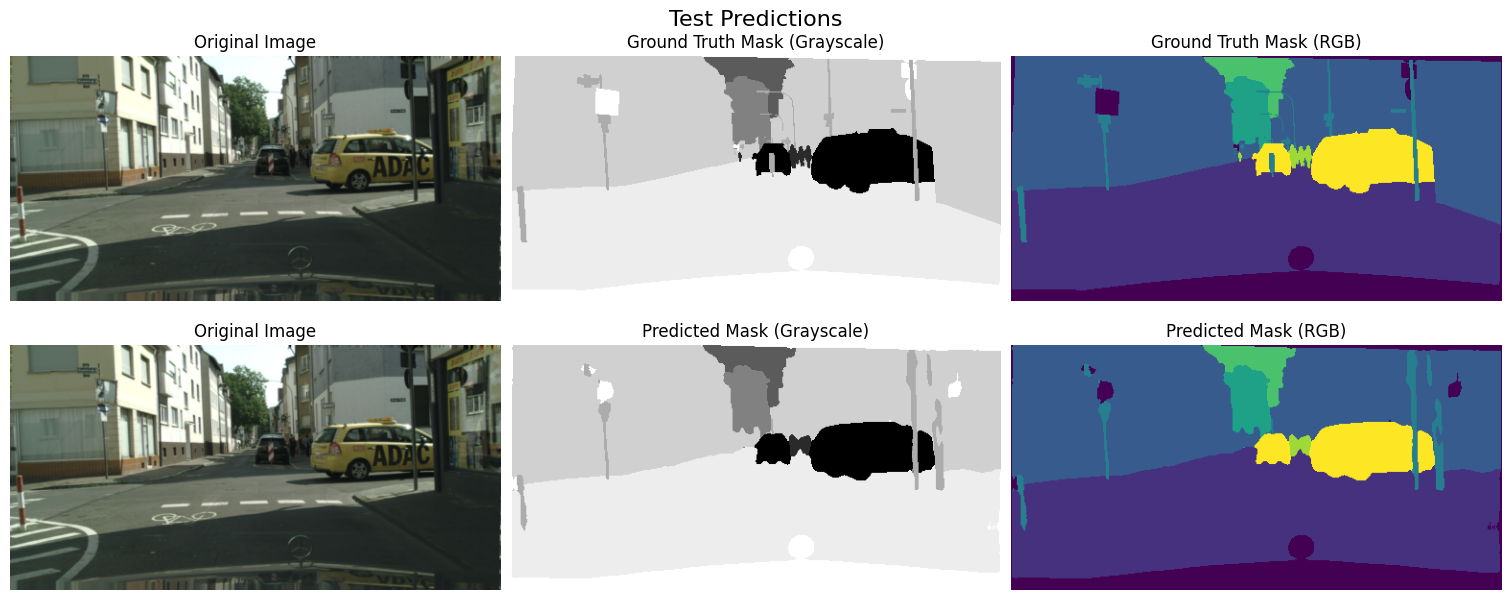

In [38]:
test_gen.show_prediction(model, 0, "Test", figsize=(15, 6))

In [104]:
pred, mask = test_gen.get_prediction(model=model, onehot=True, ground_truth=True)

1/1 [==============================] - 1s 568ms/step


In [105]:
print(mask.shape)
print(pred.shape)

(256, 512, 8)
(256, 512, 8)


In [106]:
# Étape 1 : Convertir en indices de classe
pred_classes = np.argmax(pred, axis=-1)  # Shape: (256, 512)

# Étape 2 : Reconvertir en one-hot
num_classes = pred.shape[-1]
pred_one_hot = np.eye(num_classes)[pred_classes]  # Shape: (256, 512, 8)

In [107]:
id2category = {label.categoryId: label.category for label in labels}
id2category

{0: 'void',
 1: 'flat',
 2: 'construction',
 3: 'object',
 4: 'nature',
 5: 'sky',
 6: 'human',
 7: 'vehicle'}

In [120]:
iou_mean_score = {"Mean_IoU": round(float(sm.metrics.IOUScore(class_indexes=[*range(8)])([mask], [pred]).numpy()), 4)}
iou_perclass_score = {i: round(float(sm.metrics.IOUScore(class_indexes=[i])([mask], [pred]).numpy()), 4) for i in range(8)}

In [121]:
iou_mean_score, iou_perclass_score

({'Mean_IoU': 0.819},
 {0: 0.8947,
  1: 0.9411,
  2: 0.8962,
  3: 0.3674,
  4: 0.9032,
  5: 0.9331,
  6: 0.7079,
  7: 0.9067})

In [110]:
np.mean(list(iou_perclass_score.values()))

0.8187875

In [122]:
import numpy as np
import base64
from io import BytesIO
from PIL import Image

# Convertir en Base64
def img_to_base64(img):
    buffer = BytesIO()
    img.save(buffer, format="PNG")  # PNG garde les valeurs intactes
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

def serialize_predictions(predictions, mask, class_mapping, iou_perclass_score, target_size=(1024, 2048)):
    """
    Convertit les prédictions et le mask en dictionnaires avec images en Base64.
    
    :param predictions: np.array de shape (256, 512, 8)
    :param mask: np.array de shape (256, 512, 8)
    :return: Liste de dictionnaires avec encodage Base64.
    """
    results = []
    
    for class_idx in range(predictions.shape[-1]):  # 8 classes
        gt = Image.fromarray(mask[..., class_idx].astype(np.uint8) * 255)  # Convertir en image
        gt_resized = gt.resize(target_size[::-1], Image.NEAREST)  # Resize avec NEAREST
        pred = Image.fromarray(predictions[..., class_idx].astype(np.uint8) * 255)
        pred_resized = pred.resize(target_size[::-1], Image.NEAREST)

        results.append({
            "class": class_mapping[class_idx],
            "iou": iou_perclass_score[class_idx],
            "prediction": img_to_base64(pred_resized),
            "mask": img_to_base64(gt_resized),
        })
    
    return results


In [123]:
results = serialize_predictions(pred_one_hot, mask, id2category, iou_perclass_score, target_size=(height, width))

In [124]:
results

[{'class': 'void',
  'iou': 0.8947,
  'prediction': 'iVBORw0KGgoAAAANSUhEUgAACAAAAAQACAAAAABQbOaYAAAUL0lEQVR4nO3d23baVhRA0aMO/v+X1YfYjeyCAXPRZc35YjehrpLUZI19NmKaBwBQ88/aFwAAvJ8AAIAgAQAAQafPT6Y1rwI2Zh7P/56wbwNsiQkAAAQJAAAIEgAAEDR9nkvaAYAO+wiACQAABAkAAAgSAAAQNL3i9c4At7CLAOsxAQCAIAEAAEECAACCTtcfAvAay/0j9yT5PbsU/IYJAAAECQAACBIAABDkPgAAPI19hP0wAQCAIAEAAEECAACCJq+9BWCLzu0TnLt3xKWfv/a1rnnX34vLa7v263smEwAACBIAABAkAAAgyA4AAMTMwwQAAJIEAAAECQAACBIAABAkAAAgSAAAQJAAAIAgAQAAQQIAAIIEAAAECQAACBIAABAkAAAgSAAAQJAAAIAgAQAAQQIAAIIEAAAECQAACBIAABAkAAAgSAAAQJAAAIAgAQAAQQIAAIIEAAAECQAACBIAABAkAAAgSAAAQJAAAIAgAQAAQQIAAIIEAAAECQAACBIAABAkAAAgSAAAQJAAAIAgAQAAQQIAAIIEAAAECQAACBIAABAkAAAgSAAAQJAAAIAgAQAAQQIAAIIEAAAECQAACBIAABAkAAAgSAAAQJAAAIAgAQAAQQIAAIIEAAAECQAACDqtfQF7Mo8xprUvAgCewAQAAIIEAAAECQAACLIDcKP5hp+zHwDAXpgAAECQAACAIAEAAEF2AJ7IfQIA2AsTAAAIEgAAECQAACDIDsANfroHwBh/zv0/H+OeAADsgQkAAAQJAAAIEgAAEGQH4AnO7Qgsf8w+AABbYwIAAEECAACCBAAABNkBuMHydf73/rzzfwC2yAQAAIIEAAAECQAACLIDcKNrZ/nX9gQAYEtMAAAgSAAAQJAAAIAgOwAv5B4

In [126]:
results.insert(0, iou_mean_score)

In [127]:
# Envoi au client sous format JSON (simulation)
import json
json_data = json.dumps(results)

In [130]:
# Sauvegarde le JSON
with open("../front/results.json", "w") as f:
    f.write(json_data)

In [ ]:
import requests
from PIL import Image
import io

# Ouvrir et optimiser l'image PNG
mask_path = "frankfurt_000000_000294_gtFine_labelIds.png"
image_path = "app/frankfurt_000000_000294_leftImg8bit.png"

def optimize_image(image_path):
    img = Image.open(image_path).convert("RGB")  # Convertir en RGB si nécessaire
    buffer = io.BytesIO()
    img.save(buffer, format="PNG", optimize=True)  # Compression sans perte
    buffer.seek(0)
    return buffer

files = {
    "image_file": ("image.png", optimize_image(image_path), "image/png"),
    "mask_file": ("mask.png", optimize_image(mask_path), "image/png")
}

response = requests.post("http://127.0.0.1:8000/predict/", files=files)

print(response.json())

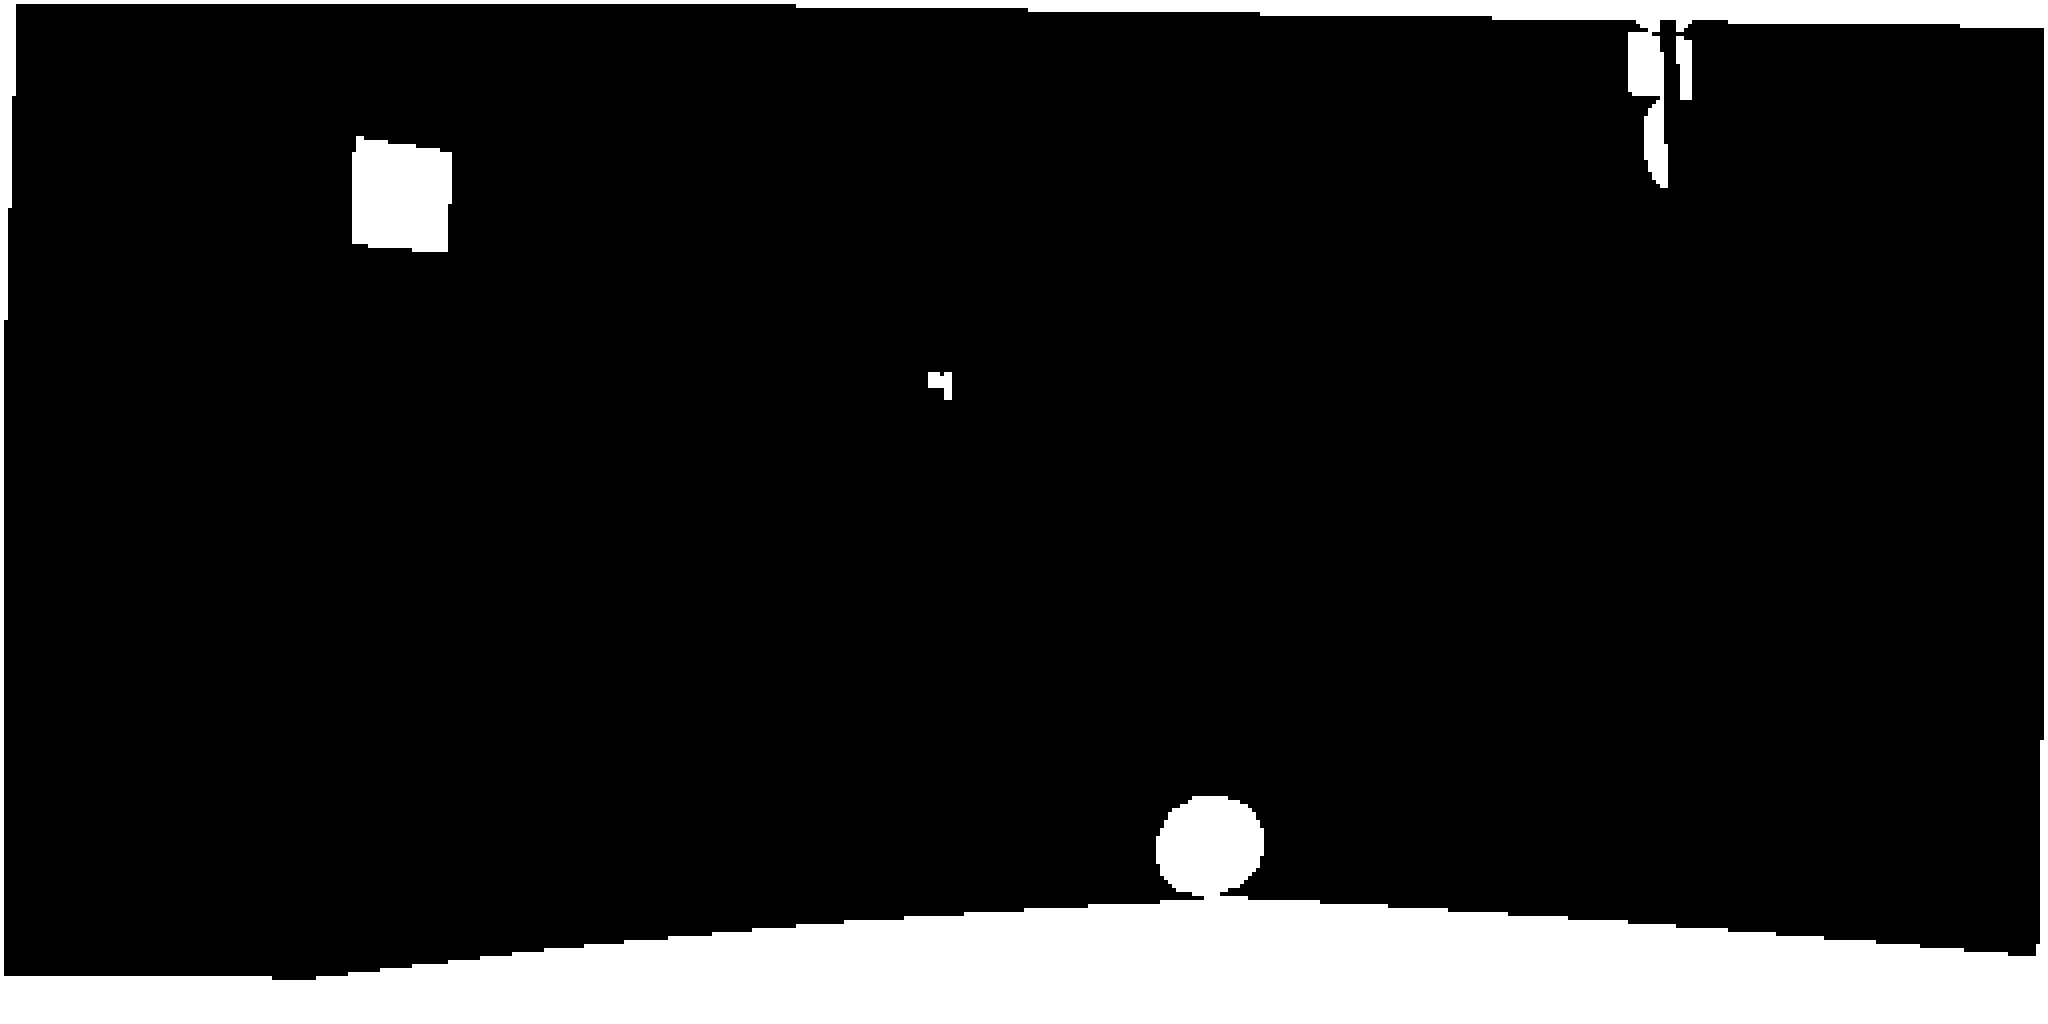

In [128]:
import base64
from PIL import Image
from io import BytesIO
import json

# Simulons la réception des données JSON
received_data = json.loads(json_data)

# Décoder la première image reçue
image_base64 = received_data[1]["mask"]  # Récupère l'image encodée en base641
image_bytes = base64.b64decode(image_base64)  # Décodage base64 → bytes
image = Image.open(BytesIO(image_bytes))  # Ouvrir l'image avec PIL

# Affichage
image.show()


In [ ]:
# Bloc avec les fonctions
def segment_image(image):
    results = model.evaluate(test_gen)
    new_masks = []
    pil_masks = []
    for i, result in enumerate(results, start=1):
        arr = np.array(result["mask"])
        pil_masks.append(arr)
        arr[arr==255] = i
        new_masks.append(arr)
    final_mask = np.sum(new_masks, axis=0).squeeze().astype(np.uint8)

    # Liste des labels pour chaque classe (excluant la classe 0 qui est l'arrière-plan)
    labels = ["Classe 1", "Classe 2", "Classe 3", "Classe 4", "Classe 5",
          "Classe 6", "Classe 7", "Classe 8", "Classe 9", "Classe 10"]



    # Créer une liste d'annotations (masques binaires + labels)
    annotations = [
        ((np.array(mask) == class_id).astype(np.uint8), label)  # (Masque binaire, Label)
        for class_id, (mask, label) in enumerate(zip(pil_masks, labels), start=1)
    ]

    return Image.fromarray(final_mask.astype(np.uint8)), (image, annotations)

In [ ]:
%%writefile main.py
from fastapi import FastAPI, UploadFile, File
import segmentation_models as sm
import shutil
import os
import uuid
from pathlib import Path
from tensorflow.keras.models import load_model
from utils_and_constants import labels, TARGET_SIZE
from data import ImageSegmentationDataset, DiceFocalLoss

app = FastAPI()

# Dossier temporaire pour stocker les images
TEMP_DIR = Path("./temp_images")
TEMP_DIR.mkdir(parents=True, exist_ok=True)

# constants.py
model_path = "./artifacts/best_model.keras"

model = load_model(
    model_path,
        custom_objects={
            "DiceFocalLoss": DiceFocalLoss,
            "MeanIoU": sm.metrics.IOUScore,
            "Dice": sm.metrics.FScore,
            **{
                f"IoU_class_{i}": sm.metrics.IOUScore(class_indexes=i) for i in range(8)
            },
        },
    )

BACKBONE = "resnet50"

def load_data(paths, labels):
    data_gen = ImageSegmentationDataset(
        paths=paths,
        labels=labels,
        batch_size=1,
        target_size=TARGET_SIZE,
        augmentations=False,
        normalize=BACKBONE,
        shuffle=False,
        label_onehot=True,
    )
    return data_gen

# Fonction pour sauvegarder un fichier temporairement et retourner son path
def save_temp_file(upload_file: UploadFile) -> Path:
    file_extension = Path(upload_file.filename).suffix  # Récupérer l'extension (.png, .jpg, ...)
    temp_filename = f"{uuid.uuid4()}{file_extension}"  # Générer un nom unique
    temp_path = TEMP_DIR / temp_filename

    with open(temp_path, "wb") as buffer:
        shutil.copyfileobj(upload_file.file, buffer)
    
    return temp_path

@app.get("/")
async def root():
    return {"message": "Hello World"}

@app.post("/predict/")
async def predict(image_file: UploadFile = File(...), mask_file: UploadFile = File(...)):
    # Sauvegarder les fichiers reçus temporairement
    image_path = save_temp_file(image_file)
    mask_path = save_temp_file(mask_file)

    # 🔥 Passer les paths au DataGenerator ou pipeline de prédiction
    data_generator = load_data([(image_path, mask_path)], labels)
    pred, mask = data_generator.get_prediction(model=model, onehot=True, ground_truth=True)

    # Optionnel : supprimer les fichiers après utilisation
    os.remove(image_path)
    os.remove(mask_path)

    return {"score": pred, "label": mask, "mask_prediction": pred, "ground_truth": mask}


Overwriting main.py
